# DATA LOAD

In [28]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
# housing.head()

In [29]:
# housing.info()

In [30]:
# housing.ocean_proximity.value_counts()

In [31]:
# housing.describe().round(2)

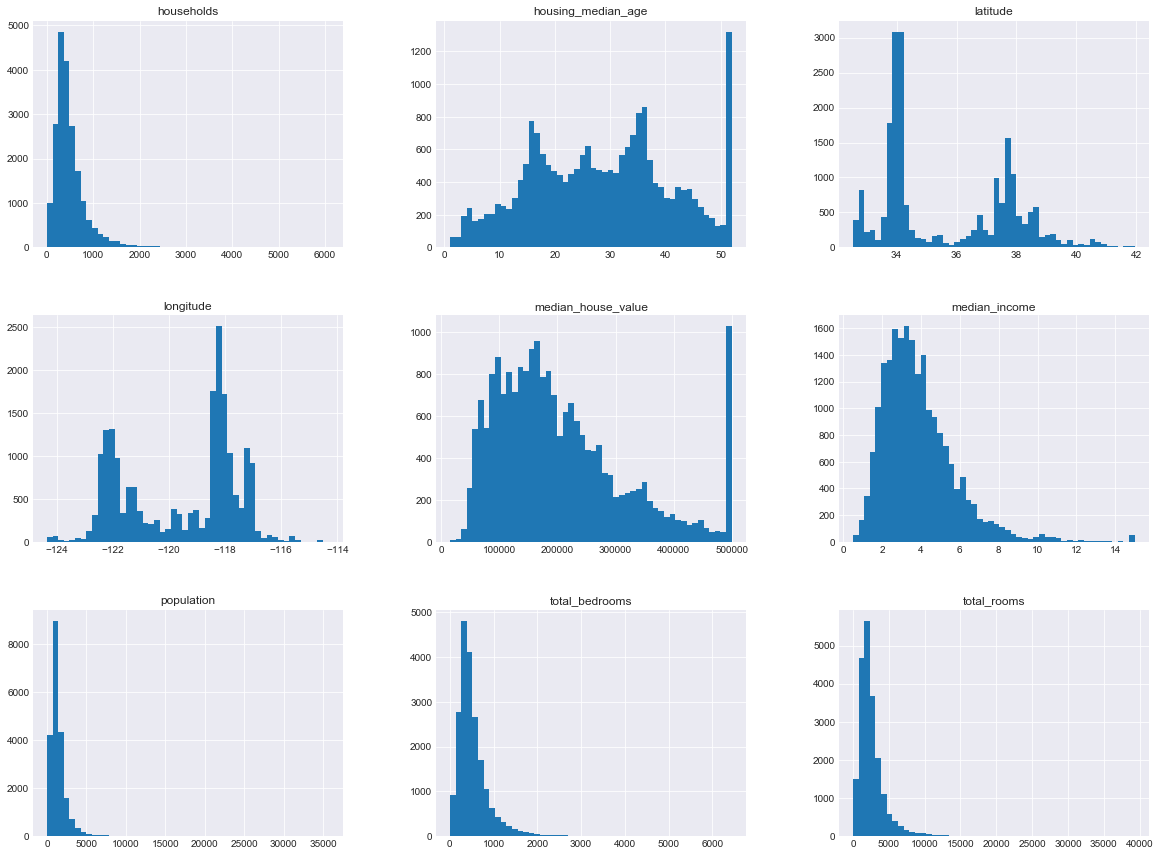

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-darkgrid') # customizing graph style
housing.hist(bins = 50, figsize = (20,15))
plt.show()

# train test split

In [32]:
import numpy as np
# 타겟변수값의 예측에 주요한 영향을 미치는 변수가 알려져 있다고 가정한다.
# 이 변수값의 값 수준이 테스트 셋에도 고르게 포함되도록 분할하는 것이 좋다.
# 해당 변수가 연속형일 경우 binning을 통해 이산화 후 계층적 sampling을 적용한다.
housing["income_cate"] = pd.cut(housing["median_income"],
                                bins = [0, 1.5, 3.0, 4.5, 6, np.inf],
                                labels = [1,2,3,4,5])
# housing["income_cate"].hist()

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
# testset이 주요변수(중간소득)의 모든 수준을 잘 대표하도록 생성
for train_index, test_index in split.split(housing, housing["income_cate"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# EDA

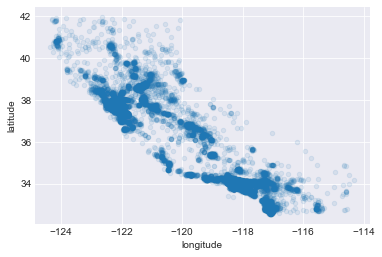

In [34]:
# 훈련셋을 복사하여 EDA용으로 사용
housing = strat_train_set.copy()

# 위도와 경도 시각화
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

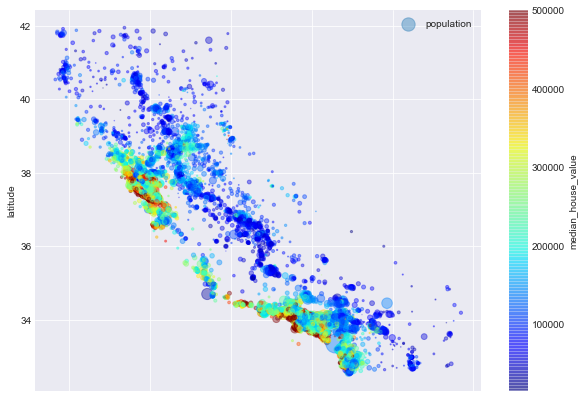

In [21]:
# 4개의 연속형변수 정보를 한번에 표현 (원의 크기, 색깔진하기, x축, y축)
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"]/100, label = "population", figsize=(10,7),
            c = "median_house_value", cmap = plt.get_cmap("jet"),colorbar = True)
plt.legend()

In [22]:
# 단순 상관관계 조사
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000222D491E888>,
      dtype=object)

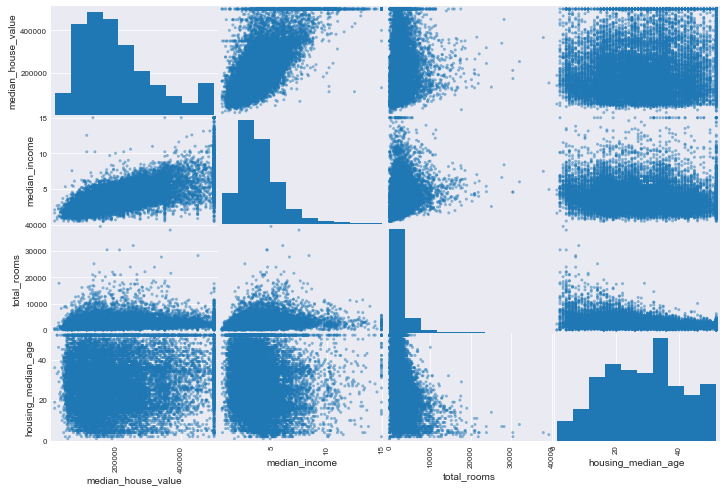

In [24]:
# 후보군을 추려 산점도행렬 그리기
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12, 8))

In [ ]:
# 다양한 특성조합 시도
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

# Data preparing

In [35]:
# data copy
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
# data cleansing
# missing value elimination / imputation
'''
housing.dropna(subset = ["total_bedrooms"]) # option1.결측인 관측들 제거
housing.drop("total_bedrooms", axis = 1) # option2.특성 통채로 제거
'''
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median, inplace = True) # option3.중앙값으로 대체

In [36]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
# 중앙값은 수치형 특성에 대해서만 계산될 수 있으므로 범주형 특성을 뺀 데이터셋을 따로 만든다.
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)

print(imputer.statistics_ )

X_num = imputer.transform(housing_num)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409    3.    ]


In [45]:
# feature engineering Functionalization
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# 파생변수 생성 자동화
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # default
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무 연산도 수행하지 않음
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [37]:
# 범주형 특성의 처리
from sklearn.preprocessing import OneHotEncoder # 명목형 범주 특성의 처리

housing_cat = housing[['ocean_proximity']]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# 혹은 pd.get_dummies(housing[['ocean_proximity']])

### preprocessing pipeline

In [46]:
# 변환 파이프라인 구축하기
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer # 열마다 다른 변환기 적용을 위한 클래스 

# 수치형 전처리 파이프라인
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# 수치형/범주형 종합 파이프라인
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

# 파이프라인을 타고 순차적으로 fit_transform 수행
housing_prepared = full_pipeline.fit_transform(housing)

# Model Selection & Traning

In [51]:
# candidate 1. Linear Regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
some_labels = housing_labels.iloc[:5]
# print("예측값 :",lin_reg.predict(some_data_prepared).round(1))
# print("실제값 :",list(some_labels))

# model evaluation - RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

# print(lin_rmse)

In [53]:
# candidate 2. decision tree 
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse) # 0.0 - overfitting

# k-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores) # outputs of cvs : negative mse
# can get multiple result scores -> can calculate variance, s.e

def display_scores(scores):
    print("\n점수 : ",scores.round(2))
    print("\n평균 : ",scores.mean().round(2))
    print("\n표준편차 : ",scores.std().round(2))

display_scores(tree_rmse_scores)

0.0

점수 :  [69384.38 66274.44 70565.69 69694.03 70547.81 76091.22 71859.63 72471.35
 77536.02 70527.82]

평균 :  71495.24

표준편차 :  3104.09


In [ ]:
# candidate 3. random forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse) 

# k-fold cross validation
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

훈련셋 점수가 검증셋 점수보다 매우 낮아 과대적합인 상태
- 규제를 가하거나
- 더 많은 훈련 데이터를 모을 수 있음

하나의 모델을 깊게 파해지치 전에, 여러 종류의 머신러닝 알고리즘으로   
하이퍼파라미터 조정에 너무 많은 시간을 들이지 않으면서 다양한 모델을 시도해봐야함.  
(Linear / RF / boosting / SVM / NN 등) 가능성있는 후보모형 2~5개 정도를 선택하는 걸 목표로
####   
#### Note
---
실험한 모델들을 모두 저장해두면 필요할 때 쉽게 모델을 복원할 수 있음.  
pickle 패키지나 joblib를 사용해 사이킷런 모델들을 간단하게 저장.

# Model Tuning

In [ ]:
# 1. grid search
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[10, 30, 50], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[10, 30], 'max_features':[2,3,4]}
] # bootstrap : sample(entire or bootstrapping) to be used generating each tree

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                         scoring = 'neg_mean_squared_error',
                         return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

In [ ]:
# 2. random search
# If the parameter search space is larger, it is more efficient than grid search.
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'n_estimators':list(range(30,100,10)), 'max_features':list(range(3,8))}
]

forest_reg = RandomForestRegressor()

r_search = RandomizedSearchCV(forest_reg, param_grid, cv = 5, n_iter = 10,
                                 scoring = 'neg_mean_squared_error',
                                 return_train_score = True)

r_search.fit(housing_prepared, housing_labels)

print(r_search.best_params_)
print(r_search.best_estimator_)
# cvres = r_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

# Testing

In [ ]:
# system evaluation with test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

# Preprocessing the same as the training set
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

# confidence interval of RMSE (using student t quantile)
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))